In [3]:
# ---- Nested function ---- #
import os
import pandas as pd
import wfdb
import ast
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
from pprint import pprint
from collections import Counter
import math
from copy import deepcopy
import random

# ---- Scipy ---- #
from scipy import signal
from scipy.signal import butter, lfilter, freqz, filtfilt

# ---- PyTorch ---- #
import torch
from torch import nn
from torch import optim
from torch import functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision.transforms import ToTensor
from torch.nn.functional import softmax
from torch.nn.parallel import DistributedDataParallel
from pytorchtools import EarlyStopping
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce


# ---- Scikit Learn ---- #
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.model_selection import KFold


# ---- Matplotlib ---- #
import matplotlib.pyplot as plt

# ---- Summary ---- #
import pytorch_model_summary


1. Transformer Encoder만 써서 12 Lead Channel의 Latent Vector를 FC Layer로 분류하는 것

2. 사실 12 Lead의 데이터는 Image나 다름없음 대신 data의 개수가 5000개니까 이를 적절하게 patch 개수로 나눠주면 ViT로 분류될 수 있을 것이라고 생각

### Data Load

In [4]:
x_whole = np.load("/data/graduate/MI_Detection_Transformer/npy_data/x_whole.npy")
y_whole = np.load("/data/graduate/MI_Detection_Transformer/npy_data/y_whole.npy")

In [5]:
x_whole.shape, y_whole.shape

((21837, 12, 5000), (21837, 5))

### Data Scaling

각 Lead 별로 Z-Score Normalization을 하는게 좋을듯

Ref : Multi-Label ECG Classification using Temporal Convolutional Neural Network

In [4]:
# Fit Transform

lead_Scaler = [StandardScaler() for _ in range(12)]
for i, xt in enumerate(x_whole):
    for j in range(12):
        r_xt = xt[j].reshape(-1,1)
        r_xt = lead_Scaler[j].fit_transform(r_xt)
        r_xt = r_xt.reshape(1,-1)
        x_whole[i][j] = r_xt

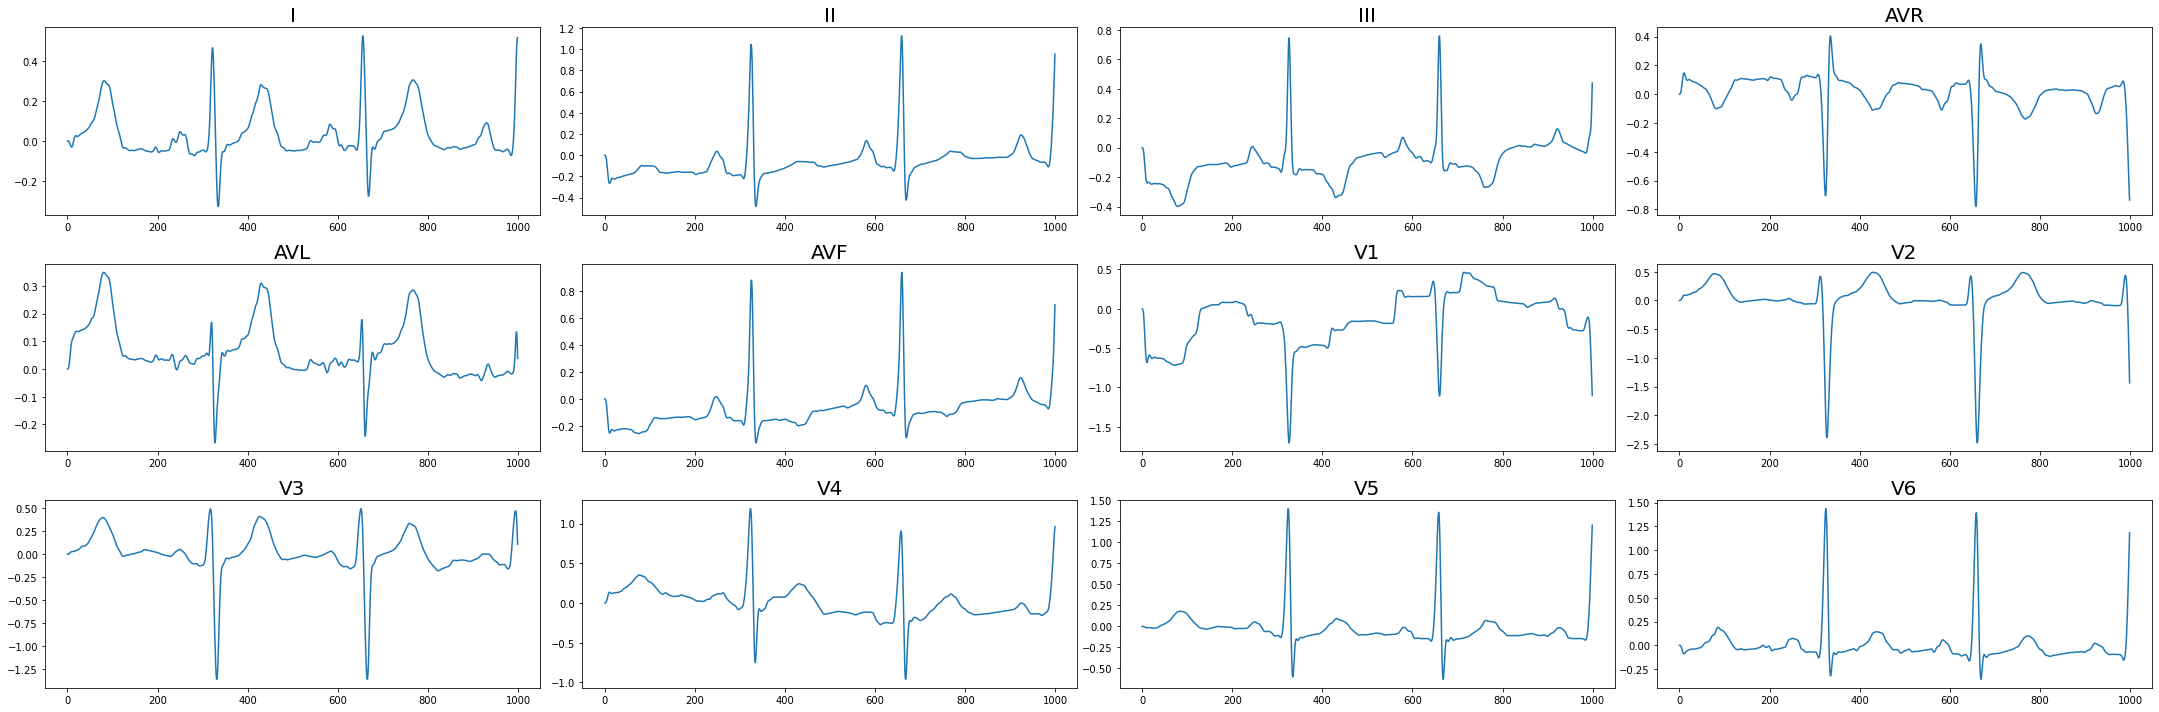

In [6]:
fig = plt.figure(figsize=(30,10))
leadNames = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
for i,lead in enumerate(leadNames):
    ax1 = fig.add_subplot(3,4,i+1)
    ax1.set_title(leadNames[i], fontsize=20)
    ax1.plot(x_whole[5][i][0:1000])
fig.tight_layout()

### Model Architecture

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class ViTEmbeddings(nn.Module):
    def __init__(self, in_channel, emb_size, patch_size, dropout=0.0):
        super().__init__()
        
        self.patch_size= patch_size
        self.emb_size= emb_size
        
        self.patch_embeddings = nn.Sequential(
            nn.Conv1d(in_channel, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange("b e (p) -> b (p) e")
        )
        self.dropout = nn.Dropout(dropout)
        
        self.cls_token = nn.Parameter(torch.randn(1, 1, self.emb_size))
        num_patches = 5000//patch_size
        self.positions = nn.Parameter(torch.randn(1, num_patches +1, self.emb_size)) ## Num Patches....어케하지
    
    def forward(self, x):
        input_shape = x.shape # B C L
#         print("Input Shape :",input_shape)
        embeddings = self.patch_embeddings(x)
#         print("Class Embedding Shape :", embeddings.shape)
        # 16 768 250 = Batch, emb_size, patch / Rearrange -> Batch, Patch, Emb_size
        cls_token = repeat(self.cls_token, "() n e -> b n e", b=input_shape[0])
        x = torch.cat([cls_token, embeddings], dim=1)
        x += self.positions
        return x
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size, num_heads, attention_bias=True ,attention_dropout=0.0, sd_survival_probability=1.0, activation="gelu", dropout=0.0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        
        self.layerNorm = nn.LayerNorm(emb_size)
#         self.MATT = nn.MultiheadAttention(emb_size, num_heads, dropout=dropout, bias=attention_bias)
        
        self.qkv = nn.Sequential( # QKV Embedding
            nn.Linear(emb_size, emb_size),
            Rearrange("b n (h d) -> b h n d", h=num_heads)
        )
        self.att_Drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        
    def forward(self, x):
        q = self.qkv(x)
        k = self.qkv(x)
        v = self.qkv(x)
        
#         print("Q shape",q.shape)
#         print("K shape",k.shape)
#         print("V shape",v.shape)
        
        
        # Attention Score
        dot_product_value = torch.einsum('bhqd, bhkd -> bhqk', q, k)
#         print("Dot product Value ",dot_product_value.shape)
        scaling = math.sqrt(self.emb_size)        
        att = softmax(dot_product_value, dim=-1)/scaling
        att = self.att_Drop(att)
#         print("Att :",att.shape)
        
        # 
        out = torch.einsum("bhal, bhlv -> bhav", att, v)
#         print("Out :",out.shape)
        out = rearrange(out, "b h n d -> b n (h d)")
#         print("Out(Rearrange) :",out.shape)
        out = self.projection(out)
#         print("Out(Linear) :",out.shape)
        
        return out
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        
    def forward(self, x, **kwargs):
        res = x 
        x = self.fn(x, **kwargs)
        x += res
        return x
class MLP(nn.Sequential):
    def __init__(self, emb_size: int = 768, expansion: int = 4, dropout=0.0):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(expansion * emb_size, emb_size)
        )
        
class EncoderBlock(nn.Sequential):
    def __init__(self, emb_size: int=768, num_heads: int=6,f_expansion: int=4, f_dropout=0.0, dropout=0.,**kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, num_heads, attention_bias=True),
                nn.Dropout(dropout)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MLP(emb_size, expansion=f_expansion, dropout=f_dropout),
                nn.Dropout(dropout)
            ))
        )
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int=6, **kwargs):
        super().__init__(*[EncoderBlock(**kwargs) for _ in range(depth)])
        
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int=768, n_classes: int=5):
        super().__init__(
            Reduce("b n e -> b e", reduction="mean"),
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, n_classes)
        )

class ViT(nn.Module):
    def __init__(self, in_channel: int= 12, patch_size: int= 20, emb_size: int= 768, num_heads: int= 6, n_classes: int= 5, depth: int= 6):
        super().__init__()
        self.in_channel = in_channel
        self.patch_size = patch_size
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.n_classes = n_classes
        self.depth = depth
        
        self.Embeddings = ViTEmbeddings(in_channel, emb_size, patch_size)
        self.TransformerEncoder = TransformerEncoder(depth)
        self.ClassificationHead = ClassificationHead(emb_size, n_classes)
        
    def forward(self, x):
        embedding = self.Embeddings(x)
#         print("Embedding Shape :",embedding.shape)
        encoder_value = self.TransformerEncoder(embedding)
#         print("Transformer Result Shape :",encoder_value.shape)
        result = self.ClassificationHead(encoder_value)
#         print("Classification Shape :",result.shape)
        return result

# Model Summary
print(pytorch_model_summary.summary(ViT().to(device), torch.zeros(16, 12, 5000).to(device), show_input=False, show_hierarchical=True , batch_size=16, print_summary=True))

In [8]:
# Evaluate
from sklearn.metrics import multilabel_confusion_matrix, classification_report

label_names = ['NORM', 'MI', 'STTC', 'HYP', 'CD']

def Evaluate(model, test_loader):
    model.eval()
    test_bar = tqdm(test_loader)
    total = len(test_loader.dataset)
    logits_list = []
    gt_list = []
    for step, (x,y) in enumerate(test_bar):
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
            logits = model(x).cpu().detach().numpy()
            logits = logits > 0.5
            logits = logits.astype(int)
            for l in logits:
                logits_list.append(l)
            y = y.cpu().detach().numpy()
            for gt in y:
                gt_list.append(gt.astype(int))
                
    return classification_report(gt_list, logits_list, target_names=label_names)

In [9]:
def get_DataLoader(x, y, batch, num_workers):
    x_tensor = torch.FloatTensor(x)
    y_tensor = torch.FloatTensor(y)
    dataset = TensorDataset(x_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch, num_workers=num_workers, shuffle=False)
    return dataloader

In [10]:
kfold = KFold(n_splits=9, shuffle=True)
fold_len = x_whole.shape[0]//9
test_len = [x_whole.shape[0]-fold_len,x_whole.shape[0]] # Fold 10
# valid_len = [x_whole.shape[0]-(fold_len*2),test_len[0]] # Fold 9
train_len = [0,test_len[0]]

x_train = x_whole[0:test_len[0]]
y_train = y_whole[0:test_len[0]]
trainset = TensorDataset(torch.FloatTensor(x_train),torch.FloatTensor(y_train))
test_loader = get_DataLoader(x_whole[test_len[0]:test_len[1]], y_whole[test_len[0]:test_len[1]], batch=32, num_workers=1)

In [11]:
x_train.shape, x_whole[test_len[0]:test_len[1]].shape

((19411, 12, 5000), (2426, 12, 5000))

In [12]:
seed = 970511
deterministic = True
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
if deterministic:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
 

lr = 1e-5
epochs = 40
# model = ViT()
criterion = nn.MultiLabelSoftMarginLoss()
# optimizer = optim.Adam(model.parameters(), lr=lr)
# early_stopping = EarlyStopping(patience=3, verbose=False)
# model.to(device)

loss_list=[]
val_loss_list = []

best_loss = np.inf
best_model = None

reports = []

model = ViT().to(device)
for fold, (train_idx, val_idx) in enumerate(kfold.split(trainset)):
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    valid_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
    
    train_loader = DataLoader(trainset,batch_size=32, sampler=train_subsampler)
    val_loader = DataLoader(trainset,batch_size=16, sampler=valid_subsampler)
    
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for ep in range(epochs):
        train_bar = tqdm(train_loader)
        
        for step, (x,y) in enumerate(train_bar):
            x, y = x.to(device), y.to(device)  
            model.train()
            
            logits = model(x)
            loss = criterion(logits, y)
            loss_list.append(loss.mean().item())
            
            loss.mean().backward()
            optimizer.step()
            train_bar.desc = "Train Epoch[{}/{}] loss: {:.3f}".format(ep+1, epochs, loss.mean().item())
            
    train_loss = 0
    valid_loss = 0
    with torch.no_grad():
        model.eval()
        print("TR LOSS CALC")
        for data in train_loader:
            inputs, values = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss_tr = criterion(outputs, values)
            
            train_loss += loss_tr.mean().item()
        
        print("VAL LOSS CALC")
        for data in val_loader:
            inputs, values = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss_vl = criterion(outputs, values)
            
            valid_loss += loss_vl.mean().item()
    
    tr_lossm = train_loss//len(train_loader)
    vl_lossm = valid_loss//len(val_loader)
    print(f"K-Fold : {fold+1}, Train_Loss : {tr_lossm}, Validation_Loss : {vl_lossm}")
    print("TEST Evaluate")
    report = Evaluate(model,test_loader)
    reports.append(report)
    print(report)

Train Epoch[15/40] loss: 0.585:  48%|███████████████▋                 | 514/1079 [00:32<00:35, 15.89it/s]


KeyboardInterrupt: 

In [17]:
reports

['              precision    recall  f1-score   support\n\n        NORM       0.74      0.63      0.68       819\n          MI       0.61      0.14      0.23       777\n        STTC       0.00      0.00      0.00       629\n         HYP       0.65      0.19      0.30       594\n          CD       0.00      0.00      0.00       305\n\n   micro avg       0.70      0.24      0.35      3124\n   macro avg       0.40      0.19      0.24      3124\nweighted avg       0.47      0.24      0.29      3124\n samples avg       0.26      0.27      0.26      3124\n',
 '              precision    recall  f1-score   support\n\n        NORM       0.75      0.61      0.67       819\n          MI       0.38      0.00      0.01       777\n        STTC       0.00      0.00      0.00       629\n         HYP       0.86      0.01      0.02       594\n          CD       0.00      0.00      0.00       305\n\n   micro avg       0.74      0.16      0.27      3124\n   macro avg       0.40      0.13      0.14      3

In [20]:
print(reports[-1])

              precision    recall  f1-score   support

        NORM       0.78      0.57      0.66       819
          MI       0.00      0.00      0.00       777
        STTC       0.39      0.18      0.24       629
         HYP       0.65      0.07      0.12       594
          CD       0.00      0.00      0.00       305

   micro avg       0.65      0.20      0.30      3124
   macro avg       0.36      0.16      0.20      3124
weighted avg       0.41      0.20      0.24      3124
 samples avg       0.25      0.22      0.23      3124

